In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import scipy.misc
import matplotlib.cm as cm
import random
from PIL import Image
from scipy.special import expit


# Multi-class Classification
## Dataset

In [6]:
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']
X.shape, y.shape

((5000, 400), (5000, 1))

In [7]:
#假如常数项系数
X = np.insert(X, 0, 1, axis=1)
X.shape

(5000, 401)

## Visualizing the data

In [8]:
#将400 转为 20*20图像
def getImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

#展示图像
def displayImg(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if indices_to_display == None:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)
    big_picture = np.zeros((height * nrows, width * ncols))
    irow , icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getImg(X[idx])
        big_picture[(irow * height):(irow * height + iimg.shape[0]),
                   (icol * width):(icol * width +iimg.shape[1])] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture,interpolation='nearest')

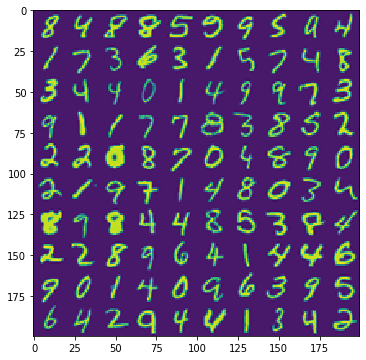

In [9]:
displayImg()

## Vectorizing logistic regression

In [10]:
#sigmod
def computeH(theta, X):
    #expit(z) = 1/(1 + exp(-z))
    return expit(X @ theta)

In [11]:
#损失函数，均方误差
def computeCost(theta, X, y, lam = 0.):
    m = X.shape[0] # 5000
    h = computeH(theta, X) # shape: (5000, 1)
    term1 = np.log(h) @ -y.T # shape : (5000, 5000)
    term2 = np.log(1 - h) @ (1 - y.T) # shape: (5000, 5000)
    left = (term1 - term2) / m # shape: (5000, 5000)
    right = theta.T @ theta * lam / (2 * m) # shape: (1, 1)
    return left + right # shape: (5000, 5000)

## Compute theta

In [12]:
#计算梯度
def computeGraident(theta, X, y, lam = 0.):
    m = X.shape[0]
    beta = computeH(theta, X) - y.T # (5000, 5000)
    regterm = theta[1:] * lam / m #shape : (400, 1)
    grad = (1. / m) * (X.T @ beta) # (401, 5000)
    grad[1:] = grad[1:] + regterm
    return grad # shape: (501, 5000)

In [13]:
from scipy import optimize

def optimizeTheta(theta, X, y, lam = 0.):
    result = optimize.fmin_cg(computeCost,
                             fprime=computeGraident,
                             x0=theta,
                             args=(X, y, lam),
                             maxiter=50,
                             disp=False,
                             full_output=True)
    return (result[0], result[1])


In [14]:
def buildTheta():
    lam = 0.
    init_theta = np.zeros((X.shape[1], 1)).reshape(-1) #(1, 401)
    theta = np.zeros((10, X.shape[1])) # (10, 401)
    for i in range(10):
        iclass = i if i else 10
        print("Optimizing for handwritten number %d..." % i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])
        itheta, iminccost = optimizeTheta(init_theta, X, logic_Y, lam)
        theta[i, :] = itheta
    print("Done!")
    return theta


In [15]:
theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


## One-vs-all classification

In [16]:
def predictOneVsAll(theta, row):
    classes = [10] 
    for i in range(1, 10):
        classes.append(i)
    hypots = [0] * len(classes)
    for i in range(len(hypots)):
        hypots[i] = computeH(theta[i], row)
    return classes[np.argmax(np.array(hypots))]

In [17]:
n_correct, n_total = 0, 0
incorrect_indices = []
for i in range(X.shape[0]):
    n_total += 1.
    if predictOneVsAll(theta, X[i]) == y[i]:
        n_correct += 1
    else:
        incorrect_indices.append(i)
print("Training set accuracy: %0.1f%%" % (100 * (n_correct / n_total)))


Training set accuracy: 95.4%


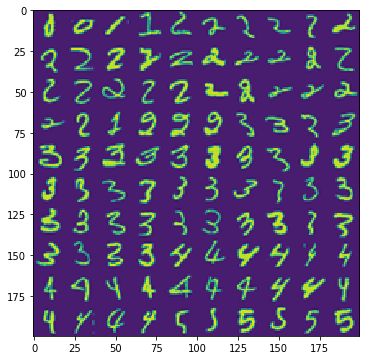

In [18]:
displayImg(incorrect_indices[:100])

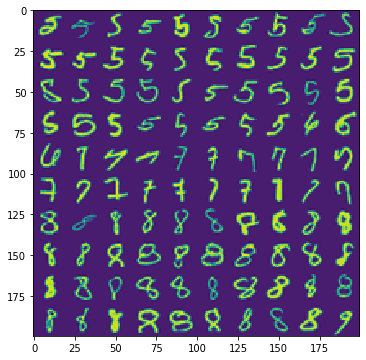

In [19]:
displayImg(incorrect_indices[100:200])

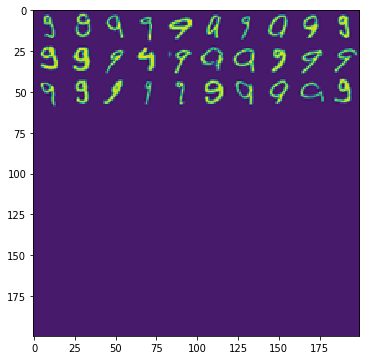

In [20]:
displayImg(incorrect_indices[200:300])

# Neural Networks

## Dataset

In [21]:
datafile2 = 'ex3weights.mat'
mat = scipy.io.loadmat(datafile2)
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

## Feedforward Propagation

In [29]:
def propagateForward(row, thetas):
    features = row
    for i in range(len(thetas)):
        theta = thetas[i]
        z = theta @ features
        print("theta:" + str(theta.shape) + "features:" + str(features.shape))
        #print(z.shape)
        a = expit(z)
        if i == len(thetas) - 1:
            return a
        a = np.insert(a, 0, 1) # Add the bias unit
        features = a
def predictNN(row, thetas):
    classes = list(range(1, 11))
    output = propagateForward(row, thetas)
    return classes[np.argmax(np.array(output))]
theta2 = [Theta1, Theta2]
n_correct2, n_total2 = 0, 0
incorrect_indices2 = []

for i in range(X.shape[0]):
    n_total2 += 1
    if predictNN(X[i], theta2) == int(y[i]):
        n_correct2 += 1
    else:
        incorrect_indices2.append(i)
print("Training set accuracy: %0.1f%%" % (100 * (n_correct2 / n_total2)))

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 

theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10, 26)features:(26,)
theta:(25, 401)features:(401,)
theta:(10

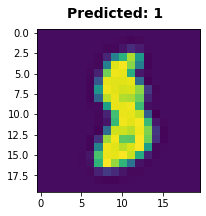

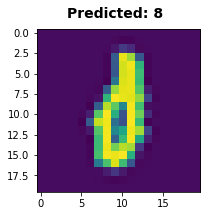

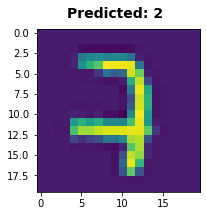

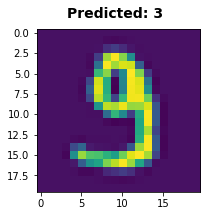

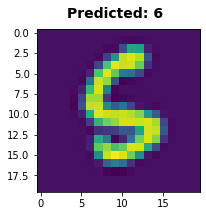

In [47]:
for x in range(5):
    i = random.choice(incorrect_indices2)
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(getImg(X[i]),interpolation='nearest')
    predicted_val = predictNN(X[i], theta2)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle("Predicted: %d" % predicted_val, fontsize=14, fontweight="bold")